# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


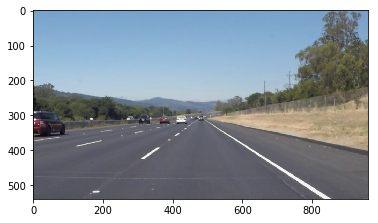

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', 
                   #for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=3):
    """
    NOTE: this is the function you might want to use as a starting point once you want to
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).

    Think about things like separating line segments by their
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of
    the lines and extrapolate to the top and bottom of the lane.

    This function draws `lines` with `color` and `thickness`.
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:             
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
    Returns the hough lines.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    #return lines
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.

    `initial_img` should be the image before any processing.

    The result image is computed as follows:

    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ) 

# Auxiliary Functions

**Function name:** `color_selection()`
- Description: This function is used to convert the image from RGB color space to HLS [(RGB<->HLS)](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html)
- Inputs: 
    * `image`: colored input image
- Outputs: 
    * `out_hls_image`: output image in HLS color-space
    
**Function name:** `moving_average()`
- Description: This function performs a simple moving average [(SMA)](https://en.wikipedia.org/wiki/Moving_average) of the input data within a given window
- Inputs: 
    * `mean_value`: current mean value to be added to the sum
    * `mov_av_accu`: accumulator that stores the mean values at each run
    * `moving_average_window`: number of samples that provide the average at each run
- Outputs: 
    * `mov_av_out`: mean value of the moving window
    
**Function name:** `average_lines()`
- Description: This function is used to average a set of lines. It separates them according to 
    their slope sign to left and right lines and outputs the mean value of their 
    respective slopes and intercepts. The function offers the choice of performing a
    moving average via 'moving_average_flag'
- Inputs: 
    * `lines`: input lines to be averaged
    * `moving_average_flag`: flag to denote whether the output will be a simple or a moving average 
- Outputs: 
    * `out_slopes_intercepts`: slopes and intercepts of both lines
    
**Function name:** `extrapolate_line()`
- Description: This function is used to extrapolate a line of a specific slope and intercept within a specified Y-range
- Inputs: 
    * `y_range`: denotes the range within minimum and maximum y `[y_bottom, y_top]` 
    * `slope_intercept`: slope and intercept of the extrapolated line
- Outputs: 
    * Extrapolated line: `[initial_point, end_point]`
        
**Function name:** `draw_extrapolated_lines()`
- Description: This function is used to draw the extrapolated lines within the specified Y-range
- Inputs: 
    * `image`: image to which the extrapolated lines will be drawn
    * `lines`: extrapolated lines to be drawn `[x1, y1, x2, y2]` 
    * `y_range`: range `[y_bottom, y_top]` in which the extrapolated lines will be drawn 
- Outputs: 
    * `combined_image`: combination of input image and extrapolated lines  
    

In [4]:
def color_selection(image):
    """
    This function is used to convert the image from RGB color space to HLS
    """
    # Change colorspace of the input image: from RGB to HLS
    hls_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

    # Define range of white and yellow color in HLS
    lower_white = np.array([20,200,0], dtype=np.uint8) 
    upper_white = np.array([255,255,255], dtype=np.uint8) 
    lower_yellow = np.array([10,50,100], dtype=np.uint8) 
    upper_yellow = np.array([100,255,255], dtype=np.uint8)  
    
    # Threshold the hls image to get the desired colors
    white_mask = cv2.inRange(hls_image, lower_white, upper_white) 
    yellow_mask = cv2.inRange(hls_image, lower_yellow, upper_yellow)

    # Bitwise-OR both masks
    white_yellow_mask = cv2.bitwise_or(white_mask, yellow_mask)
    
    # Bitwise-AND masks and original image
    out_hls_image = cv2.bitwise_and(image, image, mask = white_yellow_mask)

    return out_hls_image

def moving_average(mean_value, mov_av_accu, moving_average_window):
    """
    This function performs a simple moving average (SMA) of the input data within 
    a given window
    """
    # Append mean value to the accumulation list
    if mean_value is not None:               # if mean value for this run exists
        mov_av_accu.append(mean_value)       # append mean value
    else:                                    # else         
        mov_av_accu.append(mov_av_accu[-1])  # append previous mean av. value          

    # Get accumulator dimension (samples nr. should be less than moving average window)  
    n = np.shape(mov_av_accu) 

    # If samples nr. is more than moving average window pop sample
    if n[0] > moving_average_window:
        mov_av_accu.pop(0)
 
    # Calculate average of the moving window
    mov_av_out = np.mean(mov_av_accu, axis = 0)    
    
    return mov_av_out
    
def average_lines(lines, moving_average_flag = 0):
    """
    This function is used to average a set of lines. It separates them according to 
    their slope sign to left and right lines and outputs the mean value of their 
    respective slopes and intercepts. The function offers the choise of performing a
    moving average via 'moving_average_flag'
    """
    # Initialize local variables/arrays 
    left_slopes_intercepts = []
    right_slopes_intercepts = []
    left_length = 0
    right_length = 0

    # Separate Right and Left lines according to their slope
    for line in lines:
        for x1,y1,x2,y2 in line:
            
            # Calculate slope, intercept and line length           
            slope = ((y2-y1)/(x2-x1))
            intercept = (y1-((y2-y1)/(x2-x1))*x1)
            line_length = math.sqrt((x2-x1)**2 + (y2-y1)**2)
            
            # Calculate weighted values of slope and intercept
            # Multiplication with `line_length` gives importance to the larger line segments
            weighted_slope_intercept = [slope*line_length, intercept*line_length]

            # Separate lines 
            if x1 == x2:
                continue
            if (slope > 0 and line_length is not 0):
                left_slopes_intercepts.append(weighted_slope_intercept)
                left_length = left_length + line_length
            elif (slope < 0 and line_length is not 0):
                right_slopes_intercepts.append(weighted_slope_intercept)
                right_length = right_length + line_length
            else:
                continue

    # Transform slope-intercept (si) lists into arrays
    left_si_array = np.array(left_slopes_intercepts)
    right_si_array = np.array(right_slopes_intercepts)
    
    # Calculate left line slope and intercept mean values
    if left_length:  # Avoid division by zero
        left_si_mean_value = np.sum(left_si_array, axis=0)/left_length
    else:
        left_si_mean_value = None
    
    # Calculate right line slope and intercept mean values   
    if right_length: # Avoid division by zero
        right_si_mean_value = np.sum(right_si_array, axis=0)/right_length
    else:
        right_si_mean_value = None
    
    # Perform moving average in case it is requested (default moving_average_flag = 0)
    if moving_average_flag:        
        # Choose moving average window
        mov_av_window = 5       
        # Moving average for left line
        left_si_mov_av = moving_average(left_si_mean_value, left_mov_av_accu, mov_av_window)
        # Moving average for right line
        right_si_mov_av = moving_average(right_si_mean_value, right_mov_av_accu, mov_av_window)  
        # Save calculated mean average slope-intersept value to output array 
        out_slopes_intercepts = np.append([left_si_mov_av],[right_si_mov_av],axis = 0)
    else:        
        # Save calculated mean slope-intersept value to output array 
        out_slopes_intercepts = np.append([left_si_mean_value],[right_si_mean_value],axis = 0)

    return out_slopes_intercepts

def extrapolate_line(y_range, slope_intercept):
    """
    This function is used to extrapolate a line of a specific slope and intercept within a 
    specified region of interest (y_range)
    """
    # Derive minimum and maximum y from y_range
    y_bottom = y_range[0]
    y_top = y_range[1]

    # Extract slope and intercept
    slope, intercept = slope_intercept
    
    # Find the ini and end point of the extrapolated line 
    y_ini = y_bottom
    x_ini = (y_ini - intercept)/slope
    y_end = y_top
    x_end = (y_end - intercept)/slope
    
    return [[int(x_ini), int(y_ini), int(x_end), int(y_end)]]
    
def draw_extrapolated_lines(img, lines, y_range):
    """
    This function is used to draw the extrapolated lines whithin the specified region of interest
    """
    
    # Create an empty image to draw lines to
    line_img = np.zeros_like(img)
    
    # Get slopes and intercepts as resulted from the line averaging
    all_slopes_intercepts = average_lines(lines,1)
    
    # Extrapolate lines within the region of interest
    for slope_intercept in all_slopes_intercepts:
        if slope_intercept.all():
            extrapolated_lines = extrapolate_line(y_range, slope_intercept)
        else:
            extrapolated_lines = None

        # Draw extrapolated lines       
        if extrapolated_lines is not None: 
            draw_lines(line_img, [extrapolated_lines])
            
    # Draw the lines on the edge image
    combined_image = weighted_img(line_img, img, 0.8, 1, 0)
    
    return combined_image   

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [5]:
import os
figlist = os.listdir("test_images/")
print(figlist)

['challenge1.jpg', 'challenge2.jpg', 'solidWhiteCurve.jpg', 'solidWhiteRight.jpg', 'solidYellowCurve.jpg', 'solidYellowCurve2.jpg', 'solidYellowLeft.jpg', 'whiteCarLaneSwitch.jpg']


## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

## Pipeline function

**Function name:** `draw_lane_lines()`
- Description: This is the main pipeline used to draw lane lines into a given image.
    It involves the following steps:
    * Perform color selection
    * Perform gaussian smoothing
    * Perform canny edge detection
    * Create masked edges
    * Perform Hough transform on edge detected image
    * Draw extrapolated lines 
- Inputs: 
    * `image`: colored input image
- Outputs: 
    * `lane_line_image`: output image with drawn lane lines

In [6]:
def draw_lane_lines(image):
    """
    This is the main pipeline used to draw lane lines into a given image.
    It involves the following steps:
    * Perform color selection
    * Perform gaussian smoothing
    * Perform canny edge detection
    * Create masked edges
    * Perform Hough transform on edge detected image
    * Draw extrapolated lines    
    """
    # Image process parameters: 
    # Gaussian smoothing parameters
    kernel_size = 3
    # Canny edge detection parameters
    low_threshold = 40
    high_threshold = 100
    # Hough transform parameters
    rho = 1
    theta = np.pi/180
    threshold = 5
    min_line_len = 15
    max_line_gap = 3

    # Create a blank image to draw lines on
    line_image = np.copy(image)*0
    imshape = image.shape

    # Define region of interest 
    y_bottom = imshape[0]
    y_top = int(imshape[0]/1.5)
    left_bottom = [0, y_bottom]    
    right_bottom = [imshape[1], y_bottom]    
    left_top = [int(imshape[1]/2.4), y_top]    
    right_top = [int(imshape[1]/1.6), y_top]    
    vertices = np.array([[left_bottom, left_top, right_top, right_bottom]],dtype=np.int32)
    # Define y_range: 
    y_range = [y_bottom, y_top]
   
    # Perform color selection
    cs_image = color_selection(image)

    # Perform gaussian smoothing
    blur_cs_image = cv2.GaussianBlur(cs_image,(kernel_size, kernel_size), 0)

    # Perform canny edge detection
    edges_image = cv2.Canny(blur_cs_image, low_threshold, high_threshold)

    # Create masked edges
    masked_edges_image = region_of_interest(edges_image, vertices)

    # Run Hough on edge detected image
    hough_lines = cv2.HoughLinesP(masked_edges_image, rho, theta, threshold, np.array([]), min_line_len, max_line_gap)
    
    # Draw extrapolated lines
    lane_line_image = draw_extrapolated_lines(image, hough_lines, y_range)
    
    return lane_line_image

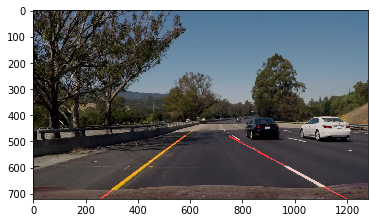

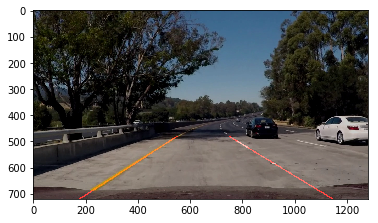

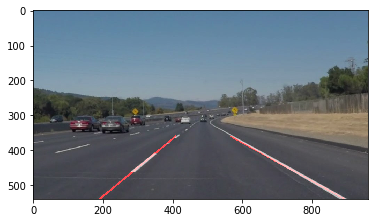

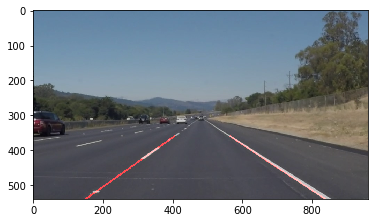

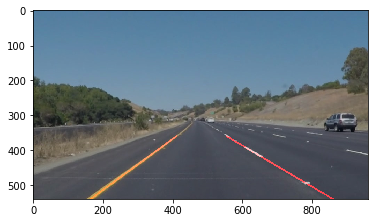

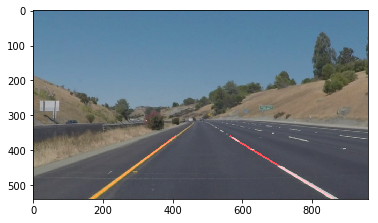

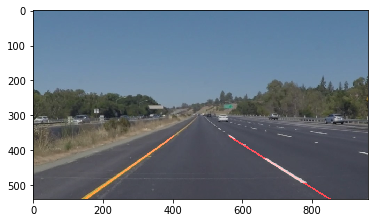

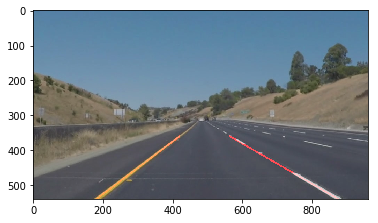

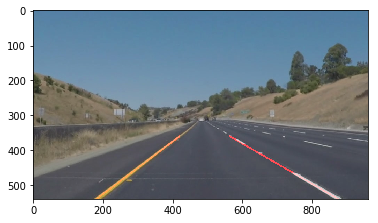

In [7]:
# Create an output directory to save the generated images
if os.path.exists('out')==False:
    os.mkdir('out')

for images in figlist:
    # Initialize empty accumulators to save the iteration results of the averaging
    left_mov_av_accu =[]
    right_mov_av_accu = []
    
    image = mpimg.imread(str('test_images/' + images))
    imshape = image.shape
    
    combined_image = draw_lane_lines(image)
    
    plt.imshow(combined_image)
    plt.show()
    out_fig = plt.imshow(combined_image)
    plt.savefig(str('out/LaneLines_' + images), dpi = 300)


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [8]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [9]:
def process_image(image):
    # Draw lane lines
    result = draw_lane_lines(image) 
    # plt.savefig(str('out/LaneLines_' + images), dpi = 300)  
    return result

Let's try the one with the solid white lane on the right first ...

In [10]:
# Initialize empty accumulators to save the iteration results of the averaging
left_mov_av_accu =[]
right_mov_av_accu = []

white_output = 'test_videos_output/solidWhiteRight.mp4'
 
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) 
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:09<00:00, 22.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 7.69 s, sys: 855 ms, total: 8.55 s
Wall time: 10.6 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [12]:
# Initialize empty accumulators to save the iteration results of the averaging
left_mov_av_accu =[]
right_mov_av_accu = []

yellow_output = 'test_videos_output/solidYellowLeft.mp4'

clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:35<00:00, 19.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 23.8 s, sys: 2.55 s, total: 26.4 s
Wall time: 36.7 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [14]:
# Initialize empty accumulators to save the iteration results of the averaging
left_mov_av_accu =[]
right_mov_av_accu = []

challenge_output = 'test_videos_output/challenge.mp4'

clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:22<00:00, 12.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 15.2 s, sys: 2.09 s, total: 17.3 s
Wall time: 25.1 s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))